# Deep Hedging AI
### Vanilla Deep Hedging engine reference implementation with dynamic training update.
### This is the main example notebook

Hans Buehler, June 30 2022


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-01-19 23:42:22.599586: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 23:42:22.764878: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-19 23:42:24.515260: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-19 23:42:24.515304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist


## Deep Hedging in a Black \& Scholes World

2023-01-19 23:42:25.351954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Gym with 1363 trainable weights compiled and initialized. Took 2s
Network feature information:
 Features used by the agent:        delta, price and time_left
 Features available to the agent:   action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by the utility:      -
 Features available to the utility: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/f31b596569d684fabd02ea4339255b87.pck'
Cache successfully loaded. Current epoch: 6
Training monitor initialized. Took 0s



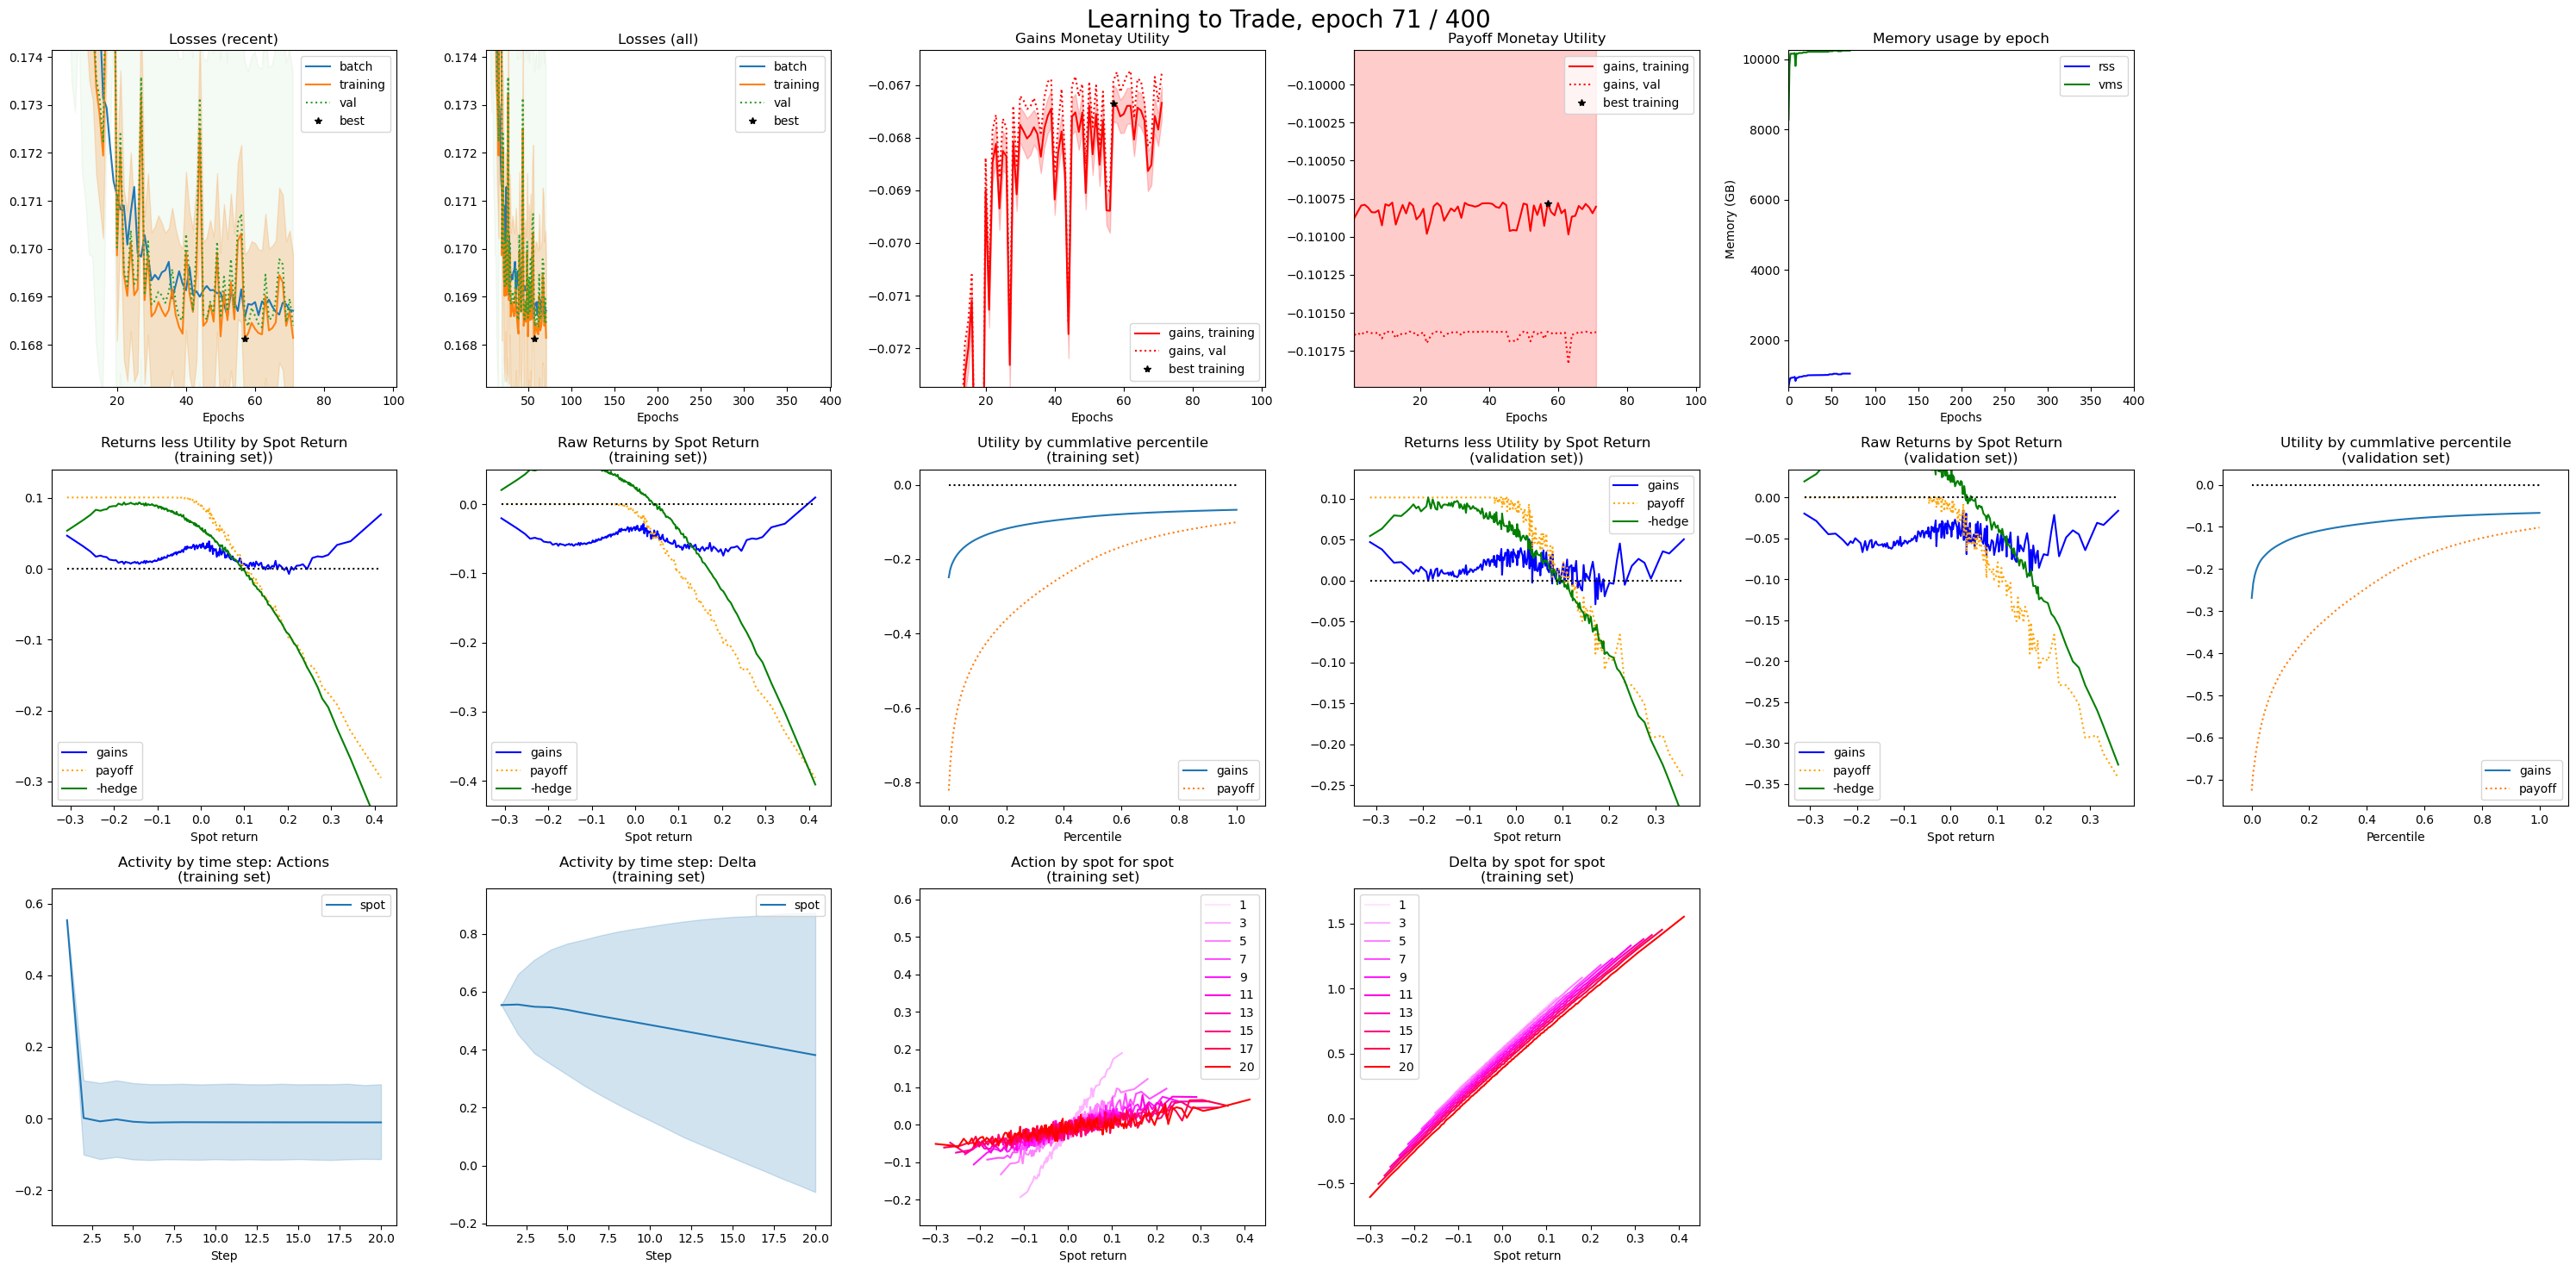

Training 72/400 epochs; 1363 weights; 10000 samples; 1000 validation samples batch size 32 | initial loss 0.343549 (0.00514204), training 0.168943 (0.0016779), best 0.168125 (0.00514204), batch 0.168824, val 0.169283 (0.00515128). Best epoch 56; last cached 70. | memory used: rss 1050.77M, vms 10249.2M | time elapsed 9:46; time per epoch 8s; estimated time remaining 54:16                         

In [ ]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence = 10 # recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.caching.mode = "on"
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()

#### Comparison to Black & Scholes

See also notebooks/blackscholes for other notebooks. Note that we use medium risk aversion, hence the hedge is not expected to match the risk-neutral hedge. See the sub directory <tt>blackscholes</tt> for experiments approximating the black & scholes solution

In [ ]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

plot_bs_hedge.plot_blackscholes( world, gym, config )

## Stochastic Vol
### Trading with two assets

In [ ]:
print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import tensorflow as tf

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = False
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 3
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence = 10 # recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.caching.mode = "on"
config.trainer.train.run_eagerly = None
config.trainer.visual.epoch_refresh = 5
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a simple Stochastic Volatility World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//10)

# create training environment
tf.debugging.enable_check_numerics()
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()